<a href="https://colab.research.google.com/github/eaedk/Machine-Learning-Tutorials/blob/main/%5BEN%5D_ML_House_Pricing_Prediction_using_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project we will try to solve a regression problem. That is, the prediction of a continuous target variable.

The objective is to predict the price of houses based on their characteristics. For this we will use this [dataset](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)  available on Kaggle.

In [1]:
!yes | pip  -q uninstall pandas-profiling
!pip -q install imblearn catboost gradio pandas-profiling[notebook,html]

     |████████████████████████████████| 76.6 MB 1.4 MB/s 
     |████████████████████████████████| 325 kB 37.5 MB/s 
     |████████████████████████████████| 62 kB 363 kB/s 
     |████████████████████████████████| 679 kB 23.2 MB/s 
     |████████████████████████████████| 102 kB 26.6 MB/s 
     |████████████████████████████████| 9.9 MB 66 kB/s 
     |████████████████████████████████| 4.7 MB 54.6 MB/s 
     |████████████████████████████████| 296 kB 57.8 MB/s 
     |████████████████████████████████| 1.6 MB 53.6 MB/s 


# Package imports

In [2]:
import pandas as pd
import urllib, os, pickle
import numpy as np
%matplotlib inline
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn import compose
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import NearMiss
# Profiling
import pandas_profiling
from pandas_profiling import ProfileReport
# Models
import xgboost
import catboost  
import lightgbm  
from sklearn import tree
from sklearn import linear_model 
from sklearn import svm 
from sklearn import neighbors 
from sklearn import ensemble 
from sklearn.dummy import DummyRegressor
from sklearn.base import clone
from sklearn.utils import all_estimators
# Setup reproductibility
np.random.seed(0)

# Data loading

## 1st approach

The dataset is in this [google drive](https://drive.google.com/drive/folders/15H8Hr8HX792zOWjUGGgTTR9FAgKMTcvz?usp=share_link). 

Add it as a shortcut to your google drive.


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

## 2nd approach

In [3]:
# train : https://drive.google.com/file/d/1rXpOmWmNU3GP1SsN_4kbY77p4ZpOitPy/view?usp=share_link
! gdown https://drive.google.com/uc?id=1rXpOmWmNU3GP1SsN_4kbY77p4ZpOitPy

# test : https://drive.google.com/file/d/1RaiP486-s3EOwjCA-ZuHdtrakNp1yD19/view?usp=share_link 
! gdown https://drive.google.com/uc?id=1RaiP486-s3EOwjCA-ZuHdtrakNp1yD19

# sample_sub : https://drive.google.com/file/d/1CMqnQ9OLrhAR1HvmhkVaYIQhKlPuxwHl/view?usp=share_link
! gdown https://drive.google.com/uc?id=1CMqnQ9OLrhAR1HvmhkVaYIQhKlPuxwHl

# data_desc : https://drive.google.com/file/d/159k7eoOm0rS8MDzixcrW6yM7Tq8T2oH4/view?usp=share_link
! gdown https://drive.google.com/uc?id=159k7eoOm0rS8MDzixcrW6yM7Tq8T2oH4

Downloading...
From: https://drive.google.com/uc?id=1rXpOmWmNU3GP1SsN_4kbY77p4ZpOitPy
To: /content/train.csv
100% 461k/461k [00:00<00:00, 110MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RaiP486-s3EOwjCA-ZuHdtrakNp1yD19
To: /content/test.csv
100% 451k/451k [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CMqnQ9OLrhAR1HvmhkVaYIQhKlPuxwHl
To: /content/sample_submission.csv
100% 31.9k/31.9k [00:00<00:00, 34.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=159k7eoOm0rS8MDzixcrW6yM7Tq8T2oH4
To: /content/data_description.txt
100% 13.4k/13.4k [00:00<00:00, 17.9MB/s]


## Data reading

In [4]:
CHALLENGE_NAME = 'House_pred'

BASE_DIR = '.'
TRAIN_FILE = os.path.join(BASE_DIR, 'train.csv')
TEST_FILE = os.path.join(BASE_DIR, 'test.csv')
SAMPLESUB_FILE = os.path.join(BASE_DIR, 'sample_submission.csv')

In [5]:
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)

# Analyze your data

In [6]:
target_cols = list(set(df_train.columns) - set(df_test.columns))
target_col = target_cols[-1]
features = df_test.columns

target_cols, target_col

(['SalePrice'], 'SalePrice')

In [ ]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
df_train.infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [ ]:
# # pandas profiling
# ## TRAIN
# profile = ProfileReport(df_train, title="Train Dataset", html={'style': {'full_width': True}})
# # profile.to_notebook_iframe()
# profile.to_file("[Trainset] Pandas-Profiling_Report.html")

In [ ]:
# # pandas profiling
# ## TEST
# profile = ProfileReport(df_test, title="Test Dataset", html={'style': {'full_width': True}})
# # profile.to_notebook_iframe()
# profile.to_file("[Testset] Pandas-Profiling_Report.html")

# Select the most interesting features

In [9]:
# for percent [0; 100] of nan in dataframe
missing_threshold = 50
check = (df_train[features].isna().sum() / ((df_train.shape[0]) / 100))

valid_features = check[check < missing_threshold].index.to_list()
check.sort_values(ascending=False)

PoolQC           99.520548
MiscFeature      96.301370
Alley            93.767123
Fence            80.753425
FireplaceQu      47.260274
                   ...    
TotalBsmtSF       0.000000
Heating           0.000000
MSSubClass        0.000000
CentralAir        0.000000
SaleCondition     0.000000
Length: 80, dtype: float64

In [10]:
df_train[valid_features].infer_objects().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [11]:
useless_features = ["Id"]
useful_features = list(set(valid_features) - set(useless_features))
print(f"[Info] '{len(useful_features)}' feature(s) to use for the next steps. ")

[Info] '75' feature(s) to use for the next steps. 


In [12]:
num_cols = df_train[useful_features].select_dtypes(include=np.number).columns.tolist()
cat_cols = df_train[useful_features].select_dtypes(exclude=np.number).columns.tolist()

print( f"Numeric features : {len(num_cols)}" )
print( f"Categorical features : {len(cat_cols)}" )

Numeric features : 36
Categorical features : 39


# Split your train dataset

In [44]:
X = df_train[useful_features]
y = df_train[target_col]

X_test_ = df_test[useful_features]

X_train_, X_eval_, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=0)
(X_train_.shape, y_train.shape) , (X_eval_.shape, y_eval.shape), (X_test_.shape)

(((1168, 75), (1168,)), ((292, 75), (292,)), (1459, 75))

# Normalize and Encode the dataset

## 1st approach

In [ ]:
# help(OneHotEncoder) # Read about categories parameter

In [14]:
# Pipeline for the Numeric features 
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

# Pipeline for the Categorical features
encoder_categories = [ df_train[cat_cols[i] ].append( df_test[cat_cols[i] ] ).dropna().unique() for i in range(len(cat_cols)) ]

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", preprocessing.OneHotEncoder(categories=encoder_categories, drop="first", sparse=False)) #if_binary
           ])
# cat_transformer.fit( pd.concat([df_train[cat_cols].dropna(),
#                  df_test[cat_cols].dropna(),
#                  ], axis=0)  ) 

# Use Numeric and Categorical Pipelines
X_train_num, X_eval_num, X_test_num = num_transformer.fit_transform(X_train_[num_cols]), num_transformer.transform(X_eval_[num_cols]), num_transformer.transform(X_test_[num_cols])

X_train_cat, X_eval_cat, X_test_cat = cat_transformer.fit_transform(X_train_[cat_cols]), cat_transformer.transform(X_eval_[cat_cols]), cat_transformer.transform(X_test_[cat_cols])

# New categorical feature names
feature_names_out = cat_transformer[-1].get_feature_names_out().tolist()
indexes = [ int(feature_names_out[i][1:feature_names_out[i].find("_")]) for i in range(len(feature_names_out))]
cat_cols_encoded = [  col.replace( f"x{i}", cat_cols[i] )  for col,i in zip(feature_names_out, indexes)]
print( f"Categorical features after encoding : {len(cat_cols_encoded)}" )

Categorical features after encoding : 200


In [ ]:
cat_cols_encoded

In [22]:
[0]+[1]

[0, 1]

In [43]:
# train df
X_train = np.concatenate([X_train_num, X_train_cat], axis=1)
df_X_train = pd.DataFrame(X_train, columns=num_cols+cat_cols_encoded)

# eval df
X_eval = np.concatenate([X_eval_num, X_eval_cat], axis=1)
df_X_eval = pd.DataFrame(X_eval, columns=num_cols+cat_cols_encoded)

# test df
X_test = np.concatenate([X_test_num, X_test_cat], axis=1)
df_X_test = pd.DataFrame(X_test, columns=num_cols+cat_cols_encoded)

In [ ]:
df_X_train.head()

,ScreenPorch,MoSold,YrSold,Fireplaces,YearBuilt,LowQualFinSF,3SsnPorch,LotArea,TotalBsmtSF,BsmtFullBath,...,Heating_Grav,Heating_Wall,Heating_OthW,Heating_Floor,LandSlope_Mod,LandSlope_Sev,GarageQual_Fa,GarageQual_Gd,GarageQual_Ex,GarageQual_Po
0,4.546911,0.256396,-0.613562,0.605438,1.188032,-0.125918,-0.115333,0.103212,1.865729,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.269109,0.623394,0.884118,-0.955603,-0.292501,-0.125918,-0.115333,-0.372881,-0.387262,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.269109,0.623394,0.884118,-0.955603,-1.641431,-0.125918,-0.115333,0.258919,-0.430962,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.269109,0.256396,0.135278,2.166479,1.023528,-0.125918,-0.115333,0.250040,1.249070,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.269109,-1.945593,-1.362401,0.605438,0.990627,-0.125918,-0.115333,0.291070,1.183519,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_X_eval.head()

,ScreenPorch,MoSold,YrSold,Fireplaces,YearBuilt,LowQualFinSF,3SsnPorch,LotArea,TotalBsmtSF,BsmtFullBath,...,Heating_Grav,Heating_Wall,Heating_OthW,Heating_Floor,LandSlope_Mod,LandSlope_Sev,GarageQual_Fa,GarageQual_Gd,GarageQual_Ex,GarageQual_Po
0,-0.269109,-1.211597,-0.613562,2.166479,-0.457005,-0.125918,-0.115333,2.063473,2.382848,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.269109,0.623394,-1.362401,2.166479,-0.983416,-0.125918,-0.115333,-0.102777,-0.600908,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.269109,0.256396,0.884118,0.605438,-0.687310,-0.125918,-0.115333,-0.334094,-0.836403,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.269109,-1.211597,0.135278,0.605438,0.201010,-0.125918,-0.115333,-0.054644,0.258531,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.269109,-1.211597,1.632958,-0.955603,0.003606,-0.125918,-0.115333,-0.832711,-1.283117,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_X_test.head()

,ScreenPorch,MoSold,YrSold,Fireplaces,YearBuilt,LowQualFinSF,3SsnPorch,LotArea,TotalBsmtSF,BsmtFullBath,...,Heating_Grav,Heating_Wall,Heating_OthW,Heating_Floor,LandSlope_Mod,LandSlope_Sev,GarageQual_Fa,GarageQual_Gd,GarageQual_Ex,GarageQual_Po
0,1.953670,-0.110602,1.632958,-0.955603,-0.325402,-0.125918,-0.115333,0.096483,-0.416395,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.269109,-0.110602,1.632958,-0.955603,-0.424104,-0.125918,-0.115333,0.343688,0.668828,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.269109,-1.211597,1.632958,0.605438,0.859024,-0.125918,-0.115333,0.302846,-0.304717,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.269109,-0.110602,1.632958,0.605438,0.891925,-0.125918,-0.115333,-0.057168,-0.309573,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.398225,-1.945593,1.632958,-0.955603,0.694521,-0.125918,-0.115333,-0.521952,0.549866,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2nd approach

In [37]:
# Pipeline for the Numeric features 
num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ("scaler", StandardScaler())]
)

# Pipeline for the Categorical features
encoder_categories = [ df_train[cat_cols[i] ].append( df_test[cat_cols[i] ] ).dropna().unique() for i in range(len(cat_cols)) ]

cat_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="most_frequent")),
           ("encoder", preprocessing.OneHotEncoder(categories=encoder_categories, drop="first", sparse=False)) #if_binary
           ])

# Associate the two pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)
X_train__, X_eval__, X_test__ = preprocessor.fit_transform(X_train_), preprocessor.transform(X_eval_), preprocessor.transform(X_test_)

# New categorical feature names
feature_names_out = preprocessor.named_transformers_['cat'][-1].get_feature_names_out().tolist()
indexes = [ int(feature_names_out[i][1:feature_names_out[i].find("_")]) for i in range(len(feature_names_out))]
cat_cols_encoded = [  col.replace( f"x{i}", cat_cols[i] )  for col,i in zip(feature_names_out, indexes)]
print( f"Categorical features after encoding : {len(cat_cols_encoded)}" )

# train df
df_X_train = pd.DataFrame(X_train__, columns=num_cols+cat_cols_encoded)

# eval df
df_X_eval = pd.DataFrame(X_eval__, columns=num_cols+cat_cols_encoded)

# test df
df_X_test = pd.DataFrame(X_test__, columns=num_cols+cat_cols_encoded)

Categorical features after encoding : 200


In [ ]:
df_X_train.head()

,ScreenPorch,MoSold,YrSold,Fireplaces,YearBuilt,LowQualFinSF,3SsnPorch,LotArea,TotalBsmtSF,BsmtFullBath,...,Heating_Grav,Heating_Wall,Heating_OthW,Heating_Floor,LandSlope_Mod,LandSlope_Sev,GarageQual_Fa,GarageQual_Gd,GarageQual_Ex,GarageQual_Po
0,4.546911,0.256396,-0.613562,0.605438,1.188032,-0.125918,-0.115333,0.103212,1.865729,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.269109,0.623394,0.884118,-0.955603,-0.292501,-0.125918,-0.115333,-0.372881,-0.387262,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.269109,0.623394,0.884118,-0.955603,-1.641431,-0.125918,-0.115333,0.258919,-0.430962,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.269109,0.256396,0.135278,2.166479,1.023528,-0.125918,-0.115333,0.250040,1.249070,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.269109,-1.945593,-1.362401,0.605438,0.990627,-0.125918,-0.115333,0.291070,1.183519,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_X_eval.head()

,ScreenPorch,MoSold,YrSold,Fireplaces,YearBuilt,LowQualFinSF,3SsnPorch,LotArea,TotalBsmtSF,BsmtFullBath,...,Heating_Grav,Heating_Wall,Heating_OthW,Heating_Floor,LandSlope_Mod,LandSlope_Sev,GarageQual_Fa,GarageQual_Gd,GarageQual_Ex,GarageQual_Po
0,-0.269109,-1.211597,-0.613562,2.166479,-0.457005,-0.125918,-0.115333,2.063473,2.382848,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.269109,0.623394,-1.362401,2.166479,-0.983416,-0.125918,-0.115333,-0.102777,-0.600908,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.269109,0.256396,0.884118,0.605438,-0.687310,-0.125918,-0.115333,-0.334094,-0.836403,1.123741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.269109,-1.211597,0.135278,0.605438,0.201010,-0.125918,-0.115333,-0.054644,0.258531,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.269109,-1.211597,1.632958,-0.955603,0.003606,-0.125918,-0.115333,-0.832711,-1.283117,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_X_test.head()

,ScreenPorch,MoSold,YrSold,Fireplaces,YearBuilt,LowQualFinSF,3SsnPorch,LotArea,TotalBsmtSF,BsmtFullBath,...,Heating_Grav,Heating_Wall,Heating_OthW,Heating_Floor,LandSlope_Mod,LandSlope_Sev,GarageQual_Fa,GarageQual_Gd,GarageQual_Ex,GarageQual_Po
0,1.953670,-0.110602,1.632958,-0.955603,-0.325402,-0.125918,-0.115333,0.096483,-0.416395,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.269109,-0.110602,1.632958,-0.955603,-0.424104,-0.125918,-0.115333,0.343688,0.668828,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.269109,-1.211597,1.632958,0.605438,0.859024,-0.125918,-0.115333,0.302846,-0.304717,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.269109,-0.110602,1.632958,0.605438,0.891925,-0.125918,-0.115333,-0.057168,-0.309573,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.398225,-1.945593,1.632958,-0.955603,0.694521,-0.125918,-0.115333,-0.521952,0.549866,-0.820747,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train your models

# Train multiple models using pipelines and compare them

In [23]:
estimator_type = 'regressor' # {"classifier", "regressor", "cluster",}    
estimators = all_estimators(type_filter=estimator_type)
random_state = 0

all_models = []
for name, EstimatorClass in estimators:
    try:
        if "CV" in name or "IC" in name or "Isotonic" in name or "Elastic" in name: continue
        if 'random_state' in EstimatorClass().get_params().keys():
            model = EstimatorClass(random_state=random_state)
        else:
            model = EstimatorClass()

        all_models.append(model)
        # print('Appending', name)
    except Exception as e:
        pass
        # print('Unable to import', name)
        # print(e)

print(f"[Info] Estimators of type '{estimator_type}' loaded: {len(all_models)}" )

[Info] Estimators of type 'regressor' loaded: 39


## 1st approach

In [24]:
# preprocessor for the raw features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, selector(dtype_include="number")),
        ("cat", cat_transformer, selector(dtype_exclude="number")),
        # ("num", num_transformer, num_cols),
        # ("cat", cat_transformer, cat_cols),
    ]
)

# end 2 end pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("estimator", None)]
)
# Grid search parameters
param_grid_ = {
    'estimator': all_models[:5], 
}

# SearchCV
end2end_grid_search = GridSearchCV(pipe, param_grid_, cv=3, scoring="neg_mean_absolute_error", refit=True, n_jobs=-1)

In [ ]:
# all_models

In [25]:
end2end_grid_search = end2end_grid_search.fit(X, y)

In [26]:
end2end_grid_search.best_params_

{'estimator': BayesianRidge()}

In [27]:
cv_results = end2end_grid_search.cv_results_

# pick out the best results
# =========================
scores_df = pd.DataFrame(cv_results)
scores_df_sorted = scores_df.sort_values(by='rank_test_score')
scores_df_sorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.180893,0.039872,0.032458,0.010267,BayesianRidge(),{'estimator': BayesianRidge()},-17968.709121,-18642.064801,-17894.838164,-18168.537362,336.189834,1
0,5.133360,1.993950,0.025128,0.000588,ARDRegression(),{'estimator': ARDRegression()},-18850.791630,-19363.501141,-18315.767786,-18843.353519,427.767686,2
2,0.404483,0.007743,0.039847,0.002428,BaggingRegressor(random_state=0),{'estimator': BaggingRegressor(random_state=0)},-19191.763450,-18714.603080,-19052.173663,-18986.180064,200.311209,3
1,0.661785,0.010673,0.052139,0.000996,AdaBoostRegressor(random_state=0),{'estimator': AdaBoostRegressor(random_state=0)},-23543.486647,-23361.365456,-24638.771842,-23847.874648,564.169484,4
4,0.191469,0.025338,0.031371,0.006887,CCA(),{'estimator': CCA()},-43566.430701,-35725.804609,-56304.486042,-45198.907117,8480.144135,5


## 2nd approach 

In [39]:
# preprocessor for the raw features
preprocessor = ColumnTransformer(
    transformers=[
        # ("num", num_transformer, selector(dtype_include="number")),
        # ("cat", cat_transformer, selector(dtype_exclude="number")),
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols),
    ]
)

# k Best variable(s) selection
selection = SelectKBest(k=1)

# end 2 end pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("univ_select", selection), ("estimator", None)]
)


# Grid search parameters
n_features_out = len(num_cols+cat_cols_encoded)
param_grid_ = {
    'univ_select__k': list(range(3, n_features_out,(n_features_out//10)))+[n_features_out],
    'estimator': all_models[:5], 
}

# SearchCV
end2end_grid_search = GridSearchCV(pipe, param_grid_, cv=3, scoring="neg_mean_absolute_error", refit=True, n_jobs=-1)

In [40]:
end2end_grid_search = end2end_grid_search.fit(X, y)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [ ]:
end2end_grid_search.best_params_

{'estimator': BayesianRidge(), 'univ_select__k': 233}

In [ ]:
cv_results = end2end_grid_search.cv_results_

# pick out the best results
# =========================
scores_df = pd.DataFrame(cv_results)
scores_df_sorted = scores_df.sort_values(by='rank_test_score')
scores_df_sorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator,param_univ_select__k,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
46,0.198836,0.004723,0.034625,0.012831,BayesianRidge(),233,"{'estimator': BayesianRidge(), 'univ_select__k...",-17968.709121,-18642.064801,-17894.838164,-18168.537362,336.189834,1
47,0.232229,0.026964,0.029769,0.006019,BayesianRidge(),236,"{'estimator': BayesianRidge(), 'univ_select__k...",-17968.709121,-18642.064801,-17894.838164,-18168.537362,336.189834,2
44,0.191705,0.005526,0.026651,0.001002,BayesianRidge(),187,"{'estimator': BayesianRidge(), 'univ_select__k...",-18153.698779,-18732.210226,-17690.275896,-18192.061634,426.231994,3
45,0.191498,0.009889,0.029841,0.003070,BayesianRidge(),210,"{'estimator': BayesianRidge(), 'univ_select__k...",-18139.474356,-18811.981608,-17744.452287,-18231.969417,440.697338,4
43,0.173334,0.012146,0.025924,0.000512,BayesianRidge(),164,"{'estimator': BayesianRidge(), 'univ_select__k...",-18371.239979,-18881.739339,-17616.409105,-18289.796141,519.769163,5
42,0.158369,0.003919,0.026461,0.001164,BayesianRidge(),141,"{'estimator': BayesianRidge(), 'univ_select__k...",-18261.776298,-19585.055032,-17793.436548,-18546.755959,758.676151,6
7,2.748261,0.816306,0.025231,0.000146,ARDRegression(),164,"{'estimator': ARDRegression(), 'univ_select__k...",-18643.043073,-19363.501166,-17716.145359,-18574.229866,674.288135,7
35,0.438539,0.019789,0.034156,0.001148,BaggingRegressor(random_state=0),236,{'estimator': BaggingRegressor(random_state=0)...,-18905.724025,-18059.440862,-18938.167284,-18634.444057,406.804332,8
29,0.339048,0.004063,0.031623,0.001226,BaggingRegressor(random_state=0),118,{'estimator': BaggingRegressor(random_state=0)...,-19109.563450,-18066.976591,-18778.591358,-18651.710466,434.987287,9
34,0.417236,0.004534,0.033671,0.000071,BaggingRegressor(random_state=0),233,{'estimator': BaggingRegressor(random_state=0)...,-19065.572895,-18636.019713,-18558.733951,-18753.442186,222.953593,10


# Apply the optimized model on the test dataset provided by Kaggle

In [45]:
test_pred = end2end_grid_search.predict(X_test_)

# Get the same prediction format as the sample_submission file

In [ ]:
sub = pd.read_csv(SAMPLESUB_FILE)
sub.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


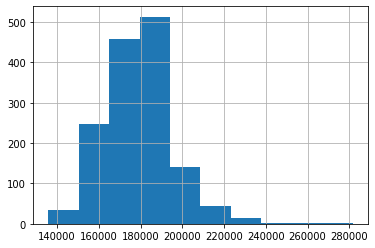

In [ ]:
sub.SalePrice.hist()

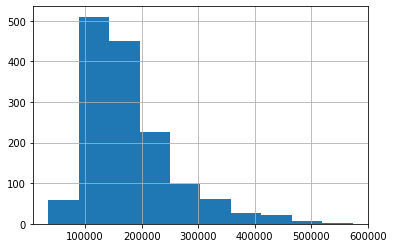

In [ ]:
sub['SalePrice'] = test_pred
sub.SalePrice.hist()

In [ ]:
sub.to_csv("init_sub.csv", index=False)

# Submit prediction to Kaggle site

Indicate below the performance obtained

# Export

In [53]:
ml = {'pipeline':end2end_grid_search.best_estimator_,
      'numeric_columns': num_cols,
      'categorical_columns': cat_cols,}

In [56]:
with open("ml_pipeline.pkl", 'wb') as file:
    pickle.dump(ml, file)

# Gradio App

In [ ]:
from IPython.utils.py3compat import encode
import gradio as gr
import numpy as np
import pandas as pd


def load_saved_objets(filepath="ml_pipeline.pkl"):
    "Function to load saved objects"

    with open(filepath, "rb") as file:
        loaded_object = pickle.load(file)

    return loaded_object


###### SETUP

loaded_object = load_saved_objets()
pipeline_of_my_app = loaded_object["pipeline"]
num_cols = loaded_object['numeric_columns']
cat_cols = loaded_object['categorical_columns']


def predict(
    BsmtFullBath,
    FullBath,
    YearRemodAdd,
    MoSold,
    MasVnrArea,
    BsmtHalfBath,
    LotArea,
    KitchenAbvGr,
    _2ndFlrSF,
    _1stFlrSF,
    BedroomAbvGr,
    GarageCars,
    WoodDeckSF,
    OverallCond,
    LowQualFinSF,
    OverallQual,
    TotalBsmtSF,
    LotFrontage,
    ScreenPorch,
    TotRmsAbvGrd,
    GarageYrBlt,
    Fireplaces,
    BsmtFinSF2,
    GrLivArea,
    PoolArea,
    BsmtFinSF1,
    EnclosedPorch,
    HalfBath,
    MiscVal,
    GarageArea,
    YearBuilt,
    MSSubClass,
    OpenPorchSF,
    YrSold,
    _3SsnPorch,
    BsmtUnfSF,
    SaleType,
    BsmtCond,
    LotConfig,
    LotShape,
    RoofStyle,
    PavedDrive,
    Functional,
    RoofMatl,
    Electrical,
    Condition1,
    LandSlope,
    BsmtQual,
    BsmtFinType1,
    Foundation,
    Heating,
    GarageQual,
    CentralAir,
    Utilities,
    GarageFinish,
    KitchenQual,
    GarageCond,
    ExterQual,
    Neighborhood,
    Condition2,
    HouseStyle,
    BsmtFinType2,
    Exterior1st,
    Exterior2nd,
    FireplaceQu,
    GarageType,
    LandContour,
    Street,
    SaleCondition,
    HeatingQC,
    MasVnrType,
    BldgType,
    BsmtExposure,
    MSZoning,
    ExterCond,
):
    """main function to collect the inputs process them and outpu the predicition"""

    df = pd.DataFrame(
        [
            [
                BsmtFullBath,
                FullBath,
                YearRemodAdd,
                MoSold,
                MasVnrArea,
                BsmtHalfBath,
                LotArea,
                KitchenAbvGr,
                _2ndFlrSF,
                _1stFlrSF,
                BedroomAbvGr,
                GarageCars,
                WoodDeckSF,
                OverallCond,
                LowQualFinSF,
                OverallQual,
                TotalBsmtSF,
                LotFrontage,
                ScreenPorch,
                TotRmsAbvGrd,
                GarageYrBlt,
                Fireplaces,
                BsmtFinSF2,
                GrLivArea,
                PoolArea,
                BsmtFinSF1,
                EnclosedPorch,
                HalfBath,
                MiscVal,
                GarageArea,
                YearBuilt,
                MSSubClass,
                OpenPorchSF,
                YrSold,
                _3SsnPorch,
                BsmtUnfSF,
                SaleType,
                BsmtCond,
                LotConfig,
                LotShape,
                RoofStyle,
                PavedDrive,
                Functional,
                RoofMatl,
                Electrical,
                Condition1,
                LandSlope,
                BsmtQual,
                BsmtFinType1,
                Foundation,
                Heating,
                GarageQual,
                CentralAir,
                Utilities,
                GarageFinish,
                KitchenQual,
                GarageCond,
                ExterQual,
                Neighborhood,
                Condition2,
                HouseStyle,
                BsmtFinType2,
                Exterior1st,
                Exterior2nd,
                FireplaceQu,
                GarageType,
                LandContour,
                Street,
                SaleCondition,
                HeatingQC,
                MasVnrType,
                BldgType,
                BsmtExposure,
                MSZoning,
                ExterCond,
            ]
        ],
        columns=num_cols + cat_cols,
    ).replace("", np.nan)

    df[cat_cols] = df[cat_cols].astype("object")  # solution of the bug
    print("df ")
    print(df.shape)
    # print(df.head())
    print(df.to_dict())

    model_output = pipeline_of_my_app.predict(df)

    print(type(model_output))
    print(model_output.shape)
    print(model_output)

    return model_output


demo = gr.Interface(
    fn=predict,
    inputs=["number" for i in (num_cols)]
    + [
        gr.inputs.Dropdown(
            choices=choices.tolist(),
            type="value",
            label=lab,
            default=choices.tolist()[0],
        )
        for (lab, choices) in zip(cat_cols, encoder_categories)
    ],
    outputs=["number"],
)


demo.launch(
    share=True,
    # debug=True,
)
